<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/01_Generalized_Linear_Models/02-01-07-04-glm-non-normal-fractional-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# Python Tutorial: Fractional Regression Models

Fractional regression models are essential for analyzing continuous proportion data—such as rates, shares, or percentages—that fall between 0 and 1. Unlike OLS or logistic regression, they handle boundary values (0s and 1s) and heteroskedasticity appropriately. In this tutorial, you’ll learn the theory, build a fractional logit model from scratch in Python, and fit it using `statsmodels`, empowering you to model real-world fractional outcomes with confidence.

## Overview

**Fractional Regression Models**, also known as `fractional logit` or `proportion` regression models, are designed for dependent variables that are bounded between 0 and 1, such as proportions, fractions, or probabilities (e.g., market shares, test scores as percentages, or budget allocations). These models ensure predictions lie within the [0,1] interval and account for the bounded nature of the data.  Examples:

- Proportion of time spent on a task
- Fraction of budget allocated to R&D
- Market share of a product
- Student test scores (as %)
- Proportion of land under cultivation

Traditional linear regression is inappropriate here because:

- Predictions can fall outside [0,1]
- Heteroskedasticity: variance depends on mean
- Non-normal errors

Logistic regression (for binary outcomes) is also inappropriate — fractional data are **continuous proportions**, not binary.


Fractional regression typically uses a **quasi-likelihood approach** based on the **logit link** and **beta distribution variance function**.

Let $y_i \in [0,1]$ be the fractional response for observation $i$.

We model the **conditional mean** $\mu_i = E(y_i | x_i)$ via a link function $g(\cdot)$:

$$
g(\mu_i) = x_i^\top \beta
$$

Commonly, $g(\cdot)$ is the **logit link**:

$$
\text{logit}(\mu_i) = \ln\left(\frac{\mu_i}{1 - \mu_i}\right) = x_i^\top \beta
$$


Instead of assuming constant variance (like OLS), we assume the variance follows the **beta distribution** structure:

$$
\text{Var}(y_i) = \phi \cdot \mu_i (1 - \mu_i)
$$

where $\phi$ is a dispersion parameter (estimated from data).

> This is a **quasi-likelihood** model — we don’t assume a full probability distribution, only mean and variance functions.



### Key Properties

- Handles responses in [0,1]
- Uses link functions (logit, probit, cloglog, etc.)
- Accounts for heteroskedasticity via variance function
- Estimates interpretable as in logistic regression (log-odds)
- Can include 0s and 1s (unlike beta regression, which requires (0,1))

### Difference Between Beta Regression and Fractional Regression

| **Aspect**                  | **Beta Regression**                                                                 | **Fractional Regression**                                                  |
|-----------------------------|------------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| **Underlying Distribution** | Assumes $y$ follows a beta distribution ($0 < y < 1$), parameterized by mean $\mu$ and precision $\phi$. | Uses a quasi-likelihood approach, specifying only mean $\mu$ and variance $\mu(1 - \mu)$. |
| **Boundary Values (0, 1)** | Excludes exact 0 or 1 unless modified (e.g., zero/one-inflated models).            | Naturally accommodates $y \in [0,1]$, including boundary values.       |
| **Estimation**             | Maximum likelihood estimation (MLE) based on beta distribution.                    | Quasi-likelihood estimation, simpler and robust to misspecification.       |
| **Flexibility**            | More flexible, models complex distributional shapes via $\phi$.               | Less flexible, focuses on mean-variance relationship.                     |
| **Applications**           | Ideal for proportions strictly between 0 and 1 (e.g., test scores).                | Suited for proportions including 0 or 1 (e.g., market shares).            |

## Fit Fractional Regression from Scratch in Python

We’ll implement **Iteratively Reweighted Least Squares (IRLS)** to fit a fractional logit model using NumPy and SciPy.

### Simulate Data

In [2]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(123)
n = 500
x1 = np.random.normal(size=n)
x2 = np.random.uniform(low=-1, high=1, size=n)
X_mat = np.column_stack([np.ones(n), x1, x2])
beta_true = np.array([-0.5, 1.2, -0.8])
eta = X_mat @ beta_true
mu = 1 / (1 + np.exp(-eta))
phi = 5
alpha = mu * phi
beta_param = (1 - mu) * phi
y = np.random.beta(alpha, beta_param)
y[np.random.choice(n, 20, replace=False)] = 0
y[np.random.choice(n, 20, replace=False)] = 1
data_scratch = pd.DataFrame({'y': y, 'x1': x1, 'x2': x2})
print(data_scratch.head())

          y        x1        x2
0  0.003273 -1.085631  0.817684
1  0.776037  0.997345 -0.675998
2  0.681365  0.282978  0.962236
3  0.029022 -1.506295  0.501495
4  0.359534 -0.578600  0.079954


### Define Logit Link and Derivatives

In [3]:
# Logit link function
def logit(p):
    return np.log(p / (1 - p))

# Inverse logit (logistic function)
def inv_logit(x):
    return 1 / (1 + np.exp(-x))

# Derivative of inverse logit: d mu / d eta
def dinv_logit(x):
    p = inv_logit(x)
    return p * (1 - p)

### Implement IRLS Algorithm

In [4]:
def fractional_logit_irls(y, X, maxit=100, tol=1e-8):
    n = len(y)
    p = X.shape[1]
    
    # Initialize coefficients
    beta = np.zeros(p)
    
    # Add small jitter to avoid 0/1 (for logit)
    y_adj = np.where(y == 0, 0.001, np.where(y == 1, 0.999, y))
    
    for iter in range(maxit):
        eta = X @ beta
        mu = inv_logit(eta)
        
        # Variance function: mu*(1-mu)
        v = mu * (1 - mu)
        weights = 1 / v  # Diagonal of weight matrix
        
        # Derivative of mu w.r.t. eta
        dmu_deta = dinv_logit(eta)
        
        # Working response (adjusted dependent variable)
        z = eta + (y_adj - mu) / dmu_deta
        
        # Weight X by multiplying each row by its weight
        X_weighted = X * weights[:, np.newaxis]
        XtWX = X.T @ X_weighted
        
        # Weight z
        z_weighted = weights * z
        XtWz = X.T @ z_weighted
        
        # Solve for new beta
        beta_new = np.linalg.solve(XtWX, XtWz)
        
        # Check convergence
        if np.sqrt(np.sum((beta_new - beta) ** 2)) < tol:
            print(f"Converged in {iter} iterations.")
            beta = beta_new
            break
        
        beta = beta_new
    
    # Recompute final fit
    eta = X @ beta
    mu = inv_logit(eta)
    
    # Estimate dispersion phi
    pearson_resid_sq = (y - mu) ** 2 / (mu * (1 - mu))
    phi_hat = np.sum(pearson_resid_sq) / (n - p)
    
    # Compute standard errors
    final_weights = 1 / (mu * (1 - mu))
    X_weighted_final = X * final_weights[:, np.newaxis]
    XtWX_final = X.T @ X_weighted_final
    cov_mat = np.linalg.inv(XtWX_final) * phi_hat
    se = np.sqrt(np.diag(cov_mat))
    
    # Inference
    z_scores = beta / se
    p_values = 2 * stats.norm.cdf(-np.abs(z_scores))
    
    return {
        'coefficients': beta,
        'se': se,
        'z_values': z_scores,
        'p_values': p_values,
        'fitted_values': mu,
        'residuals': y - mu,
        'phi': phi_hat,
        'iterations': iter
    }

### Fit the Model

In [5]:
from scipy import stats

# Fit model
X_mat = np.column_stack([np.ones(len(data_scratch)), data_scratch['x1'], data_scratch['x2']])
model_scratch = fractional_logit_irls(data_scratch['y'], X_mat)

# Display results
print("=== Fractional Logit Model (From Scratch) ===")
results_df = pd.DataFrame({
    'Coefficient': model_scratch['coefficients'],
    'Std_Error': model_scratch['se'],
    'Z_value': model_scratch['z_values'],
    'P_value': model_scratch['p_values']
}, index=['Intercept', 'x1', 'x2'])
print(results_df)
print(f"\nEstimated dispersion (phi): {model_scratch['phi']}")

Converged in 26 iterations.
=== Fractional Logit Model (From Scratch) ===
           Coefficient  Std_Error     Z_value        P_value
Intercept    -0.524795   0.010325  -50.826213   0.000000e+00
x1            1.242119   0.007170  173.240485   0.000000e+00
x2           -0.570728   0.016366  -34.872547  1.938763e-266

Estimated dispersion (phi): 0.3414279189357896


### Validate Model (Basic Diagnostics)

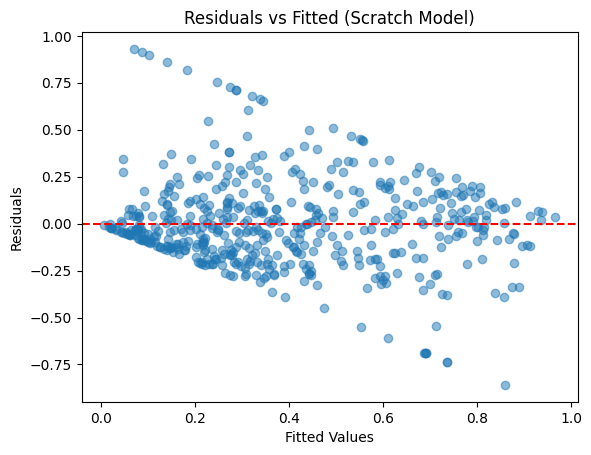

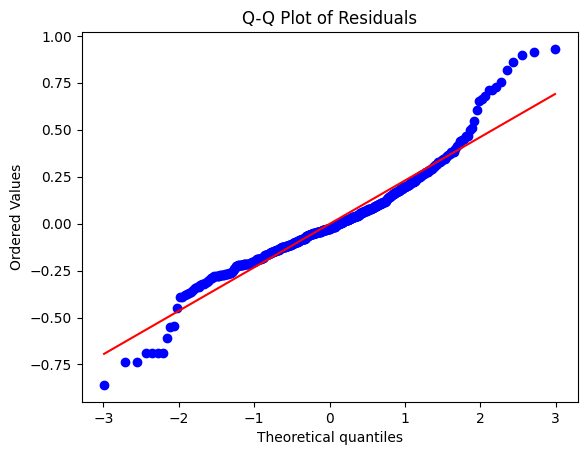

In [6]:
import matplotlib.pyplot as plt

# Residuals vs Fitted
plt.scatter(model_scratch['fitted_values'], model_scratch['residuals'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (Scratch Model)')
plt.show()

# Q-Q plot (approximate, since not normal)
stats.probplot(model_scratch['residuals'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

## Fit Fractional Regression Using `statsmodels`

In Python, we can use `statsmodels` with the `GLM` class and `family=Binomial(link=logit)` to fit a fractional logit model, which is equivalent to R’s `glm(..., family=quasibinomial(link="logit"))`. Note that `statsmodels` does not have a direct `quasibinomial` family, but `Binomial` with robust standard errors can approximate it.

### Load Python Packages

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

### Data

We’ll use a synthetic dataset similar to R’s `GasolineYield`, as the original is not available in Python. We simulate data with similar characteristics.

In [11]:
# Simulate GasolineYield-like data
np.random.seed(123)
n = 32
data_gas = pd.DataFrame({
    'yield_prop': np.random.beta(5, 5, n),  # Proportion between 0 and 1
    'gravity': np.random.normal(40, 5, n),
    'pressure': np.random.uniform(5, 15, n),
    'temp10': np.random.normal(250, 20, n),
    'temp': np.random.normal(500, 50, n)
})
data_gas['yield_prop'][np.random.choice(n, 5, replace=False)] = 0
data_gas['yield_prop'][np.random.choice(n, 5, replace=False)] = 1

# Validate data
print("Column names:", data_gas.columns.tolist())
print("\nData info:")
print(data_gas.info())
print("\nYield_prop description:")
print(data_gas['yield_prop'].describe())
print("\nMissing values:")
print(data_gas.isna().sum())

Column names: ['yield_prop', 'gravity', 'pressure', 'temp10', 'temp']

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yield_prop  32 non-null     float64
 1   gravity     32 non-null     float64
 2   pressure    32 non-null     float64
 3   temp10      32 non-null     float64
 4   temp        32 non-null     float64
dtypes: float64(5)
memory usage: 1.4 KB
None

Yield_prop description:
count    32.000000
mean      0.504882
std       0.320075
min       0.000000
25%       0.313050
50%       0.479850
75%       0.753392
max       1.000000
Name: yield_prop, dtype: float64

Missing values:
yield_prop    0
gravity       0
pressure      0
temp10        0
temp          0
dtype: int64


/tmp/ipykernel_23602/4256974431.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_gas['yield_prop'][np.random.choice(n, 5, replace=False)] = 0
/tmp/ipykernel_23602/4256974431.py:12: FutureWarning: ChainedAssignmentError: behaviour wi

### Fit with `statsmodels`

In [12]:
# Fit fractional logit model
model_glm = smf.glm(
    formula='yield_prop ~ gravity + pressure + temp10 + temp',
    data=data_gas,
    family=sm.families.Binomial(link=sm.families.links.Logit())
).fit(cov_type='HC0')  # Robust standard errors
print(model_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             yield_prop   No. Observations:                   32
Model:                            GLM   Df Residuals:                       27
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17.105
Date:                Tue, 16 Sep 2025   Deviance:                       15.893
Time:                        22:25:11   Pearson chi2:                     12.1
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02453
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.9568      4.271     -0.926      0.3

### Visualize Coefficients

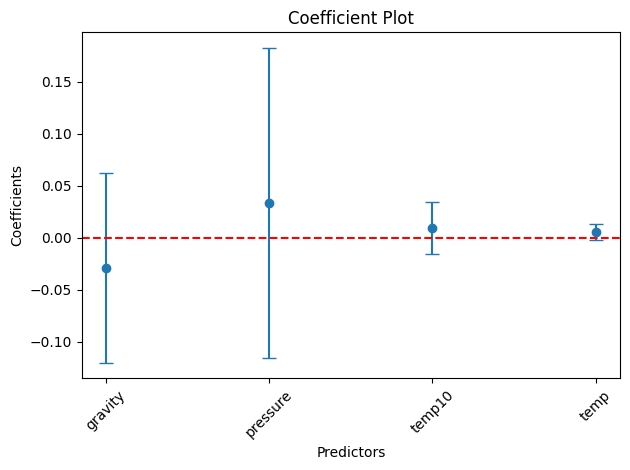

In [13]:
# Plot coefficients
coefs = model_glm.params[1:]  # Exclude intercept
se = model_glm.bse[1:]
predictors = coefs.index
plt.errorbar(predictors, coefs, yerr=1.96 * se, fmt='o', capsize=5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predictors')
plt.ylabel('Coefficients')
plt.title('Coefficient Plot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Marginal Effects

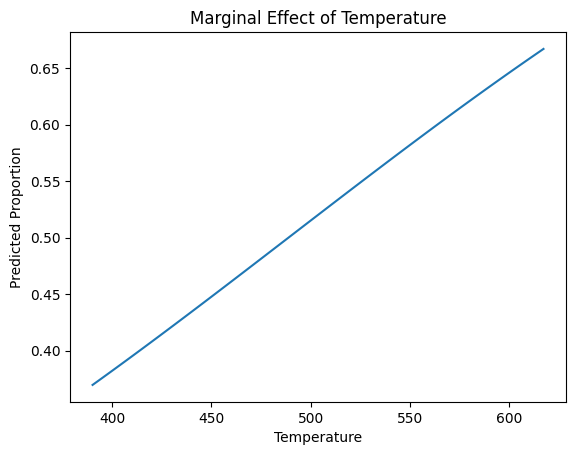

In [14]:
from statsmodels.genmod.generalized_linear_model import GLMResults

# Compute average marginal effects for 'temp'
temp_range = np.linspace(data_gas['temp'].min(), data_gas['temp'].max(), 100)
marginal_effects = []
for temp in temp_range:
    new_data = data_gas.mean().to_frame().T
    new_data['temp'] = temp
    pred = model_glm.predict(new_data)
    marginal_effects.append(pred[0])

plt.plot(temp_range, marginal_effects)
plt.xlabel('Temperature')
plt.ylabel('Predicted Proportion')
plt.title('Marginal Effect of Temperature')
plt.show()

### Predictions and Interpretation

In [16]:
# Predict on new data
new_data = pd.DataFrame({
    'gravity': [40],
    'pressure': [10],
    'temp10': [250],
    'temp': [500]
})
pred_logit = model_glm.predict(new_data, linear=True)
pred_prob = model_glm.predict(new_data)
print(f"Predicted log-odds: {pred_logit[0]}")
print(f"Predicted proportion: {pred_prob[0]}")

# Interpret coefficients: one-unit increase in temp → multiplicative change in odds
print(f"Odds multiplier per unit temp: {np.exp(model_glm.params['temp'])}")

Predicted log-odds: 0.11762561350592757
Predicted proportion: 0.5293725451650912
Odds multiplier per unit temp: 1.0054249344832293


/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


## Summary and Conclusions

This tutorial taught you how to model proportion data (bounded between 0 and 1) using fractional regression in Python—both from scratch and with `statsmodels`. You implemented a custom IRLS algorithm for fractional logit models and compared it to the standard `statsmodels.GLM` approach with robust standard errors, which is recommended for real-world use. You now understand when to use fractional regression (instead of OLS or logistic), how to interpret coefficients as log-odds, and how to handle 0s and 1s—equipping you to analyze rates, shares, and percentages across economics, ecology, education, and beyond.

## Resources

1. Papke, L. E., & Wooldridge, J. M. (1996). Econometric methods for fractional response variables with an application to 401(k) plan participation rates. *Journal of Applied Econometrics*, 11(6), 619–632.
2. Ferrari, S., & Cribari-Neto, F. (2004). Beta regression for modelling rates and proportions. *Journal of Applied Statistics*, 31(7), 799–815.